## Data-X - projekt - verze 4

In [69]:
!pip install imblearn
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [70]:
# Basics
from google.colab import drive
import numpy as np
import pandas as pd
from collections import Counter

In [71]:
# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.figure_factory as ff
import plotly.colors as pc

In [136]:
# scikit-learn
from sklearn.model_selection import (train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV)
from sklearn.preprocessing import (MinMaxScaler, LabelEncoder)
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score)
from sklearn import metrics

In [73]:
from imblearn.over_sampling import (RandomOverSampler)
from scipy import stats
from xgboost import XGBClassifier

In [74]:
seed = 543

In [75]:
# Setting the number of decimal places to 2
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [76]:
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/penguins.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data preprocessing

### Exploratory analysis

In [77]:
data.shape # (rows, columns)

(363, 8)

In [78]:
data.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.10,18.70,181.00,3750.00,male,2007
1,Adelie,Torgersen,39.50,17.40,186.00,3800.00,female,2007
2,Adelie,Torgersen,40.30,18.00,195.00,3250.00,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.70,19.30,193.00,3450.00,female,2007


In [79]:
data.tail()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
358,Chinstrap,Dream,43.50,18.10,202.00,3400.00,female,2009
359,Chinstrap,Dream,49.60,18.20,193.00,3775.00,male,2009
360,Chinstrap,Dream,50.80,19.00,210.00,4100.00,male,2009
361,Chinstrap,Dream,50.20,18.70,198.00,3775.00,female,2009
362,Chinstrap,Dream,NaN,NaN,NaN,NaN,NaN,2009


In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363 entries, 0 to 362
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            363 non-null    object 
 1   island             363 non-null    object 
 2   bill_length_mm     358 non-null    float64
 3   bill_depth_mm      358 non-null    float64
 4   flipper_length_mm  357 non-null    float64
 5   body_mass_g        358 non-null    float64
 6   sex                349 non-null    object 
 7   year               363 non-null    int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 22.8+ KB


In [81]:
# Unique values for categorical columns
for col in ['species', 'island', 'sex', 'year']:
    print(col+ ':', list(data[col].unique()))

species: ['Adelie', 'Gentoo', 'Chinstrap']
island: ['Torgersen', 'Biscoe', 'Dream']
sex: ['male', 'female', nan]
year: [2007, 2008, 2009]


The penguins dataset has **363 observations**, **7 independent variables** and 1 dependent variable. **5** of the features **are numerical** and **2 are categorical** (year can be treated as categorical). The **target variable consists of 3 categories**.

The columns:

* **species**: penguin species (Chinstrap, Adélie, or Gentoo)
* **island**: island name (Dream, Torgersen, or Biscoe) 
* **bill_length_mm**: bill length (mm)
* **bill_depth_mm**: bill depth (mm)
* **flipper_length_mm**: flipper length (mm)
* **body_mass_g**: body mass (g)
* **sex**: penguin sex
* **year**: year

We can see that there are some **missing values** in the data that need to be handled (deleted or imputed). Also the **data types** of some columns should be corrected.

In [82]:
# Categorical variables
for i in list(data.columns[data.dtypes == 'object']):
    data[i] = data[i].astype('category')
data['year'] = data['year'].astype('category')
data.dtypes

species              category
island               category
bill_length_mm        float64
bill_depth_mm         float64
flipper_length_mm     float64
body_mass_g           float64
sex                  category
year                 category
dtype: object

In [83]:
# Checking missing values per columns
data.isna().sum()

species               0
island                0
bill_length_mm        5
bill_depth_mm         5
flipper_length_mm     6
body_mass_g           5
sex                  14
year                  0
dtype: int64

In [84]:
# Checking missing values per rows
data['nans'] = data.isnull().sum(axis=1)
data[data['nans'] > 0].sort_values(by = ['nans'], ascending = False).head(10)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year,nans
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007,5
287,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN,2009,5
337,Chinstrap,Dream,NaN,NaN,NaN,NaN,NaN,2009,5
346,Chinstrap,Dream,NaN,NaN,NaN,NaN,NaN,2009,5
362,Chinstrap,Dream,NaN,NaN,NaN,NaN,NaN,2009,5
8,Adelie,Torgersen,34.10,18.10,193.00,3475.00,NaN,2007,1
9,Adelie,Torgersen,42.00,20.20,190.00,4250.00,NaN,2007,1
10,Adelie,Torgersen,37.80,17.10,186.00,3300.00,NaN,2007,1
11,Adelie,Torgersen,37.80,17.30,180.00,3700.00,NaN,2007,1
37,Adelie,Biscoe,37.50,18.60,NaN,3150.00,female,2007,1


Rows with too many missing data (5 of 7 explanatory variables) will be deleted. Rows with 1 missing value will be imputed after splitting the data set into training and testing part.

In [85]:
# Deleting rows with too many NaNs
data = data.loc[(data['nans'] < 5)]

# Deleting column with counted NaNs
data = data.drop('nans', axis=1)

In [86]:
# Checking missing values for columns
data.isna().sum()

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    1
body_mass_g          0
sex                  9
year                 0
dtype: int64

In [87]:
# Checking for duplicates
print('There are',data.duplicated().sum(), 'duplicated rows.')

# Displaying the duplicated rows along with their original row
data[data.duplicated(keep = False)].sort_values(by = list(data.columns))

There are 11 duplicated rows.


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.10,18.70,181.00,3750.00,male,2007
16,Adelie,Torgersen,39.10,18.70,181.00,3750.00,male,2007
19,Adelie,Torgersen,39.10,18.70,181.00,3750.00,male,2007
1,Adelie,Torgersen,39.50,17.40,186.00,3800.00,female,2007
17,Adelie,Torgersen,39.50,17.40,186.00,3800.00,female,2007
20,Adelie,Torgersen,39.50,17.40,186.00,3800.00,female,2007
2,Adelie,Torgersen,40.30,18.00,195.00,3250.00,female,2007
18,Adelie,Torgersen,40.30,18.00,195.00,3250.00,female,2007
21,Adelie,Torgersen,40.30,18.00,195.00,3250.00,female,2007
233,Chinstrap,Dream,45.20,17.80,198.00,3950.00,female,2007


In [88]:
# Deleting duplicates
data.drop_duplicates(inplace = True)

In [89]:
data.shape # (rows, columns)

(347, 8)

In [90]:
# Checking the values of numerical variables
numerical_statistics = pd.concat([
    data.describe(include = np.number).iloc[0:1],
    data.mode(numeric_only = True).rename(index = {0:'mode'}),
    pd.DataFrame(data.median(numeric_only = True), columns = ['median']).T,
    data.describe(include = np.number).iloc[1:8],
    ])
numerical_statistics

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,347.00,347.00,346.00,347.00
mode,41.10,17.00,190.00,3800.00
median,44.50,17.30,197.00,4000.00
mean,43.94,17.17,200.81,4191.35
std,5.46,1.97,14.02,801.49
min,32.10,13.10,172.00,2700.00
25%,39.25,15.60,190.00,3550.00
50%,44.50,17.30,197.00,4000.00
75%,48.50,18.70,213.00,4750.00
max,59.60,21.50,231.00,6300.00


In [91]:
# Checking the values of categorical variables
data.describe(include = 'category')

,species,island,sex,year
count,347,347,338,347
unique,3,3,2,3
top,Adelie,Biscoe,male,2009
freq,153,169,170,119


### Data visualisation

#### Categorical variables

In [92]:
# Count the frequency of each value in the 'species' and 'island' columns and create a bar charts
species_counts = Counter(data['species'])
island_counts = Counter(data['island']) 

fig = make_subplots(rows = 1, cols = 2, subplot_titles = ("Species Counts", "Islands Counts"))

fig.add_trace(go.Bar(x = list(species_counts.keys()), y = list(species_counts.values()), marker_color = ['brown', 'coral', 'gold']),
              row = 1, col = 1)

fig.add_trace(go.Bar(x = list(island_counts.keys()), y = list(island_counts.values()), marker_color = ['pink', 'violet', 'indigo']),
              row = 1, col = 2)

fig.update_layout(height = 500, width = 1500, showlegend = False)
fig.show()

print('Count of each species: ' + str(species_counts))
print('Count of each island: ' + str(island_counts))

Count of each species: Counter({'Adelie': 153, 'Gentoo': 123, 'Chinstrap': 71})
Count of each island: Counter({'Biscoe': 169, 'Dream': 127, 'Torgersen': 51})


Distribution of the target variable seems to be slightly imbalanced. The **Adelie** is the majority specie, followed by **Gentoo** and the third specie causing the major imbalance is **Chinstrap** specie.

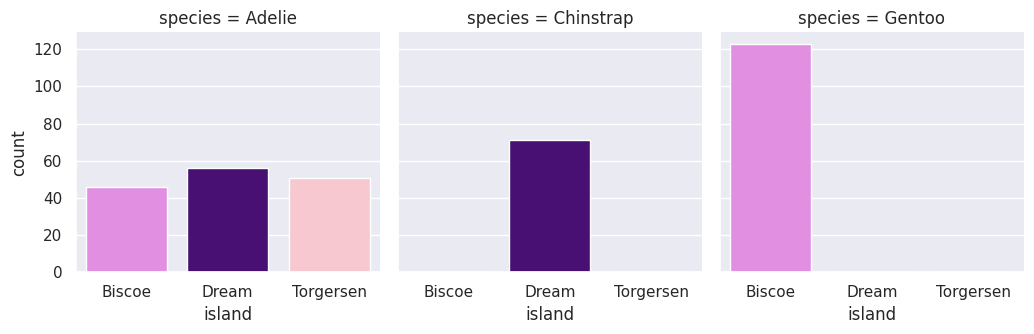

In [93]:
# Show more detail - combine the above graphs
fig2 = px.bar(data, x = 'island', color = 'species', title = "Species per Island")
fig2.update_layout(autosize = False, width = 800, height = 500)
fig2.show()

sns.catplot(data = data, x = 'island', col = 'species', kind = 'count', height = 3.5, palette = {'Torgersen':'pink', 'Biscoe':'violet', 'Dream':'indigo'})

From the graph showing species distribution per islands it is visible that:

1) on the **Torgersen** island only the **Adelie** specie can be found, 

2) **Gentoo** specie lives only on **Biscoe** island, and 

3) **Chinstrap** specie lives only on **Dream** island.

In [94]:
# Count the frequency of each value in the 'year' column and create a bar chart
year_counts = Counter(data['year'])

fig = go.Figure(data = [go.Bar(x = list(year_counts.keys()), y = list(year_counts.values()), marker_color = ['darkcyan', 'cadetblue', 'darkturquoise'])])
fig.update_layout(title = "Observations per Year", autosize = False, width = 800, height = 500)
fig.show()

print('Observations in years: ' + str(year_counts))

Observations in years: Counter({2009: 119, 2007: 114, 2008: 114})


Number of observations each year is balanced.

In [95]:
# Count the frequency of each value in the 'sex' column and create a donut chart
data['sex'] = np.where(data['sex'].isna(), 'unknown', data['sex']) # replace NaNs with a placeholder value and add a new category for them
sex_counts = data['sex'].value_counts()

fig0 = px.pie(names = sex_counts.index, values = sex_counts.values, title = 'Sex Distribution', labels = {'names': 'Sex', 'values': 'Count'}, hole = 0.4)
fig0.update_layout(autosize = False, width = 700, height = 400)
fig0.show()

print('Count of each sex: ' + str(Counter(data['sex'])))

Count of each sex: Counter({'male': 170, 'female': 168, 'unknown': 9})


In [96]:
# Show more detail
fig1 = px.bar(data, x='species', color='sex', color_discrete_sequence = ['red', 'blue', 'green'])
fig2 = px.bar(data, x='island', color='sex', color_discrete_sequence = ['red', 'blue', 'green'])
fig3 = px.bar(data, x='year', color='sex', color_discrete_sequence = ['red', 'blue', 'green'])

figures = [fig1, fig2, fig3]

fig = make_subplots(rows = 1, cols = len(figures), subplot_titles = ("per Specie", "per Island", "per Year")) 

for i, figure in enumerate(figures):
    for trace in range(len(figure['data'])):
        fig.append_trace(figure['data'][trace], row = 1, col = i+1)

fig.update_layout(height = 400, width = 1500, showlegend = False)
fig.show()

All the graphs above show that **sex variable is balanced throughout the dataset** as a whole, per species, per island, as well as per year.

#### Numerical variables

<img src='https://drive.google.com/uc?export=view&id=1wFmMUpf-zvhFh9MxRq2x9k19qNXHHi7M' width="500">

In [97]:
species_colors = {'Adelie': 'brown', 'Chinstrap': 'coral', 'Gentoo': 'gold'}

In [98]:
# Histogram of bill_length_mm per species
fig2 = ff.create_distplot([data[data['species'] == sp]['bill_length_mm'] for sp in data['species'].unique()], 
                          data['species'].unique(), 
                          bin_size = 1, 
                          show_rug = False, 
                          colors = [species_colors[sp] for sp in data['species'].unique()])

fig2.update_layout(autosize = False, width = 800, height = 500, title_text = 'Histogram of bill_length_mm per species')
fig2.show()

# Violin plot
fig3 = go.Figure(data = [go.Violin(x = data['species'], y = data['bill_length_mm'], box_visible = True, fillcolor = 'lightblue')])
fig3.update_layout(autosize = False, width = 800, height = 500, title_text = 'Violin plot of bill_length_mm per species')
fig3.show()

The **Adelie** specie seems to have **shorter bills** on average compared to other species.

In [99]:
# Histogram of bill_depth_mm per species
fig2 = ff.create_distplot([data[data['species'] == sp]['bill_depth_mm'] for sp in data['species'].unique()], 
                          data['species'].unique(), 
                          bin_size = 0.3, 
                          show_rug = False, 
                          colors = [species_colors[sp] for sp in data['species'].unique()])

fig2.update_layout(autosize = False, width = 800, height = 500, title_text = 'Histogram of bill_depth_mm per species')
fig2.show()

# Violin plot
fig3 = go.Figure(data = [go.Violin(x = data['species'], y = data['bill_depth_mm'], box_visible = True, fillcolor = 'lightblue')])
fig3.update_layout(autosize = False, width = 800, height = 500, title_text = 'Violin plot of bill_depth_mm per species')
fig3.show()

The **Gentoo** specie seems to have **less deep bills** on average compared to other species.

In [100]:
# Histogram of flipper_length_mm per species
data_dropped = data.dropna(subset=['flipper_length_mm']) # dropping NaN values for plotting purposes

fig2 = ff.create_distplot([data_dropped[data_dropped['species'] == sp]['flipper_length_mm'] for sp in data_dropped['species'].unique()], 
                          data_dropped['species'].unique(), 
                          bin_size = 2, 
                          show_rug = False, 
                          colors = [species_colors[sp] for sp in data_dropped['species'].unique()])

fig2.update_layout(autosize = False, width = 800, height = 500, title_text = 'Histogram of flipper_length_mm per species')
fig2.show()

# Violin plot
fig3 = go.Figure(data = [go.Violin(x = data['species'], y = data['flipper_length_mm'], box_visible = True, fillcolor = 'lightblue')])
fig3.update_layout(autosize = False, width = 800, height = 500, title_text = 'Violin plot of flipper_length_mm per species')
fig3.show()

The **Gentoo** specie seems to have **longer flippers** on average compared to other species.

In [101]:
# Histogram of body_mass_g per species
fig2 = ff.create_distplot([data[data['species'] == sp]['body_mass_g'] for sp in data['species'].unique()], 
                          data['species'].unique(), 
                          bin_size = 100, 
                          show_rug = False, 
                          colors = [species_colors[sp] for sp in data['species'].unique()])

fig2.update_layout(autosize = False, width = 800, height = 500, title_text = 'Histogram of body_mass_g per species')
fig2.show()

# Violin plot
fig3 = go.Figure(data = [go.Violin(x = data['species'], y = data['body_mass_g'], box_visible = True, fillcolor = 'lightblue')])
fig3.update_layout(autosize = False, width = 800, height = 500, title_text = 'Violin plot of body_mass_g per species')
fig3.show()

The **Gentoo** specie seems to have **bigger body mass** on average compared to other species.

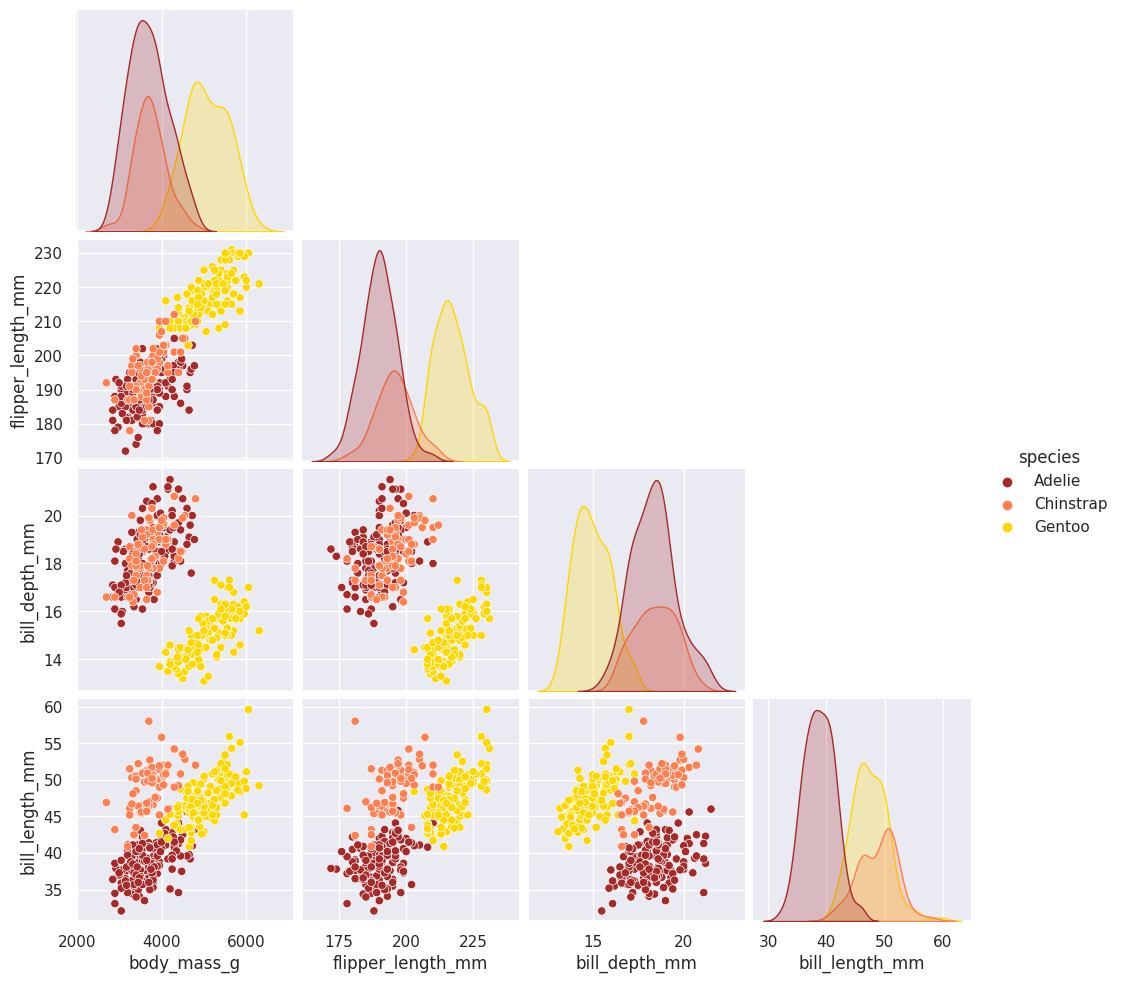

In [102]:
# Scatter plots for numerical variables
sns.pairplot(data, hue = "species", vars = ['body_mass_g', 'flipper_length_mm', 'bill_depth_mm', 'bill_length_mm'], corner = True, palette = species_colors)

<Axes: >

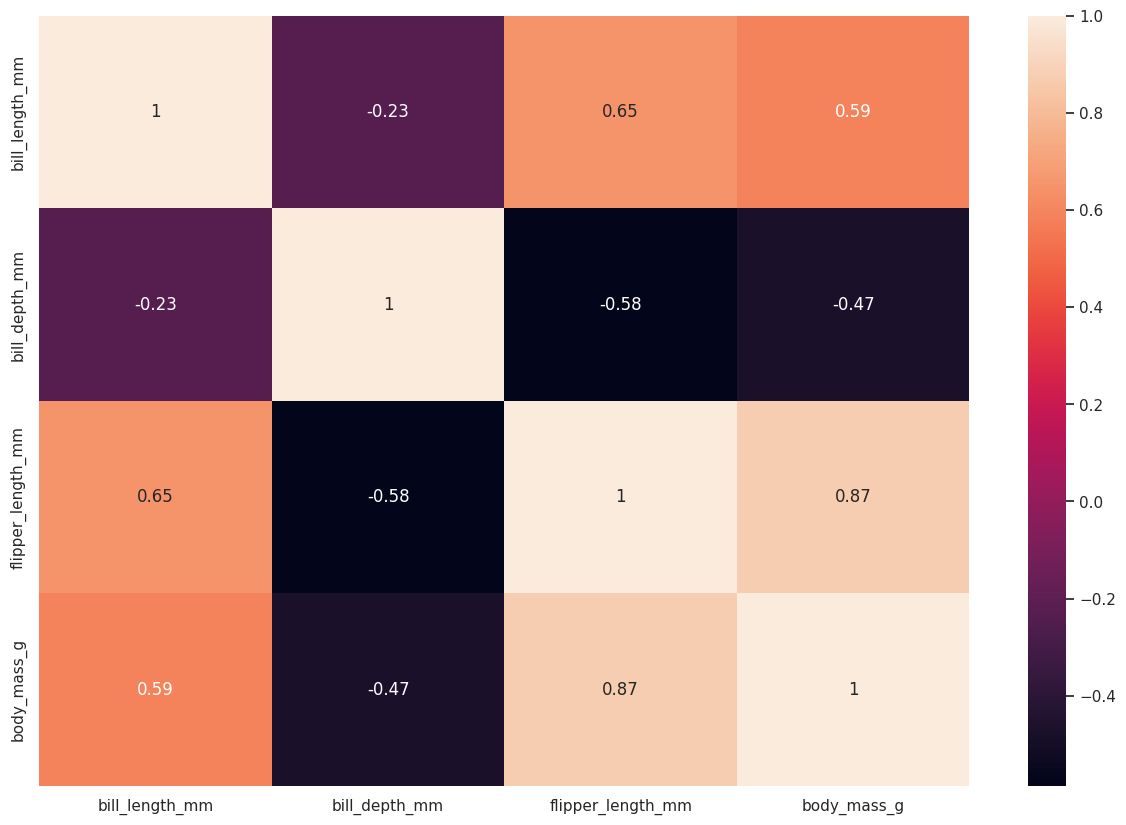

In [103]:
# Checking for correlation between independent numerical variables
sns.heatmap(data.corr(numeric_only = True), annot = True)

<Axes: >

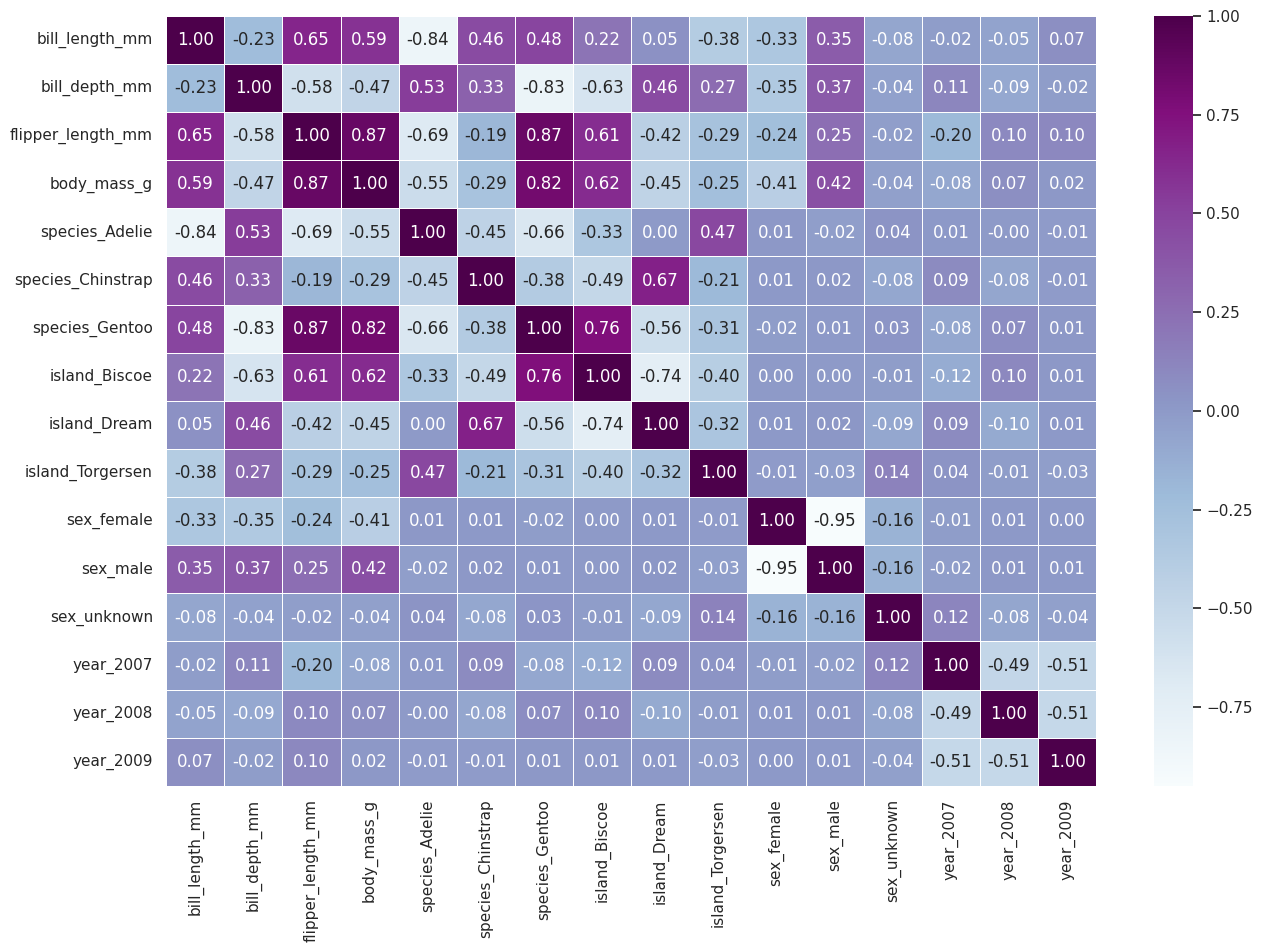

In [104]:
# Checking for correlation between all variables
dummies = pd.get_dummies(data)
sns.set(rc = {'figure.figsize':(15, 10)})
sns.heatmap(data = dummies.corr(),
            annot = True,
            cmap = 'BuPu',
            fmt = '.2f', 
            linewidth = .5)

From both the pairplot and the correlogram we can see that the columns **flipper_length_mm** and **body_mass_g** are strongly positively correlated - the higher the body mass, the longer the flipper.

We decided to delete the column flipper_length_mm. Also the column year will be deleted.


In [105]:
# Dropping columns
data.drop('flipper_length_mm', axis = 1, inplace = True) # dopišme někam vysvětlení, proč jsme zrovna tenhle sloupec vyhodili (možná taky proto, že měl jednu chybějící hodnotu?)
data.drop('year', axis = 1, inplace = True)

### Splitting data

In [106]:
# Encoding the categorical variables
data = pd.get_dummies(data, columns = ['island'], drop_first = False)
data = pd.get_dummies(data, columns = ['sex'], drop_first = True)
data.head()

,species,bill_length_mm,bill_depth_mm,body_mass_g,island_Biscoe,island_Dream,island_Torgersen,sex_male,sex_unknown
0,Adelie,39.10,18.70,3750.00,0,0,1,1,0
1,Adelie,39.50,17.40,3800.00,0,0,1,0,0
2,Adelie,40.30,18.00,3250.00,0,0,1,0,0
4,Adelie,36.70,19.30,3450.00,0,0,1,0,0
5,Adelie,39.30,20.60,3650.00,0,0,1,1,0


In [107]:
# Setting unknown sex to NaN again
data.loc[data['sex_unknown'] == 1, 'sex_male'] = np.nan

# Deleting column 'sex_unknown'
data = data.drop('sex_unknown', axis=1)

In [108]:
# Splitting the data set into training and testing part
x_train, x_test, y_train, y_test = train_test_split(data.drop(['species'], axis = 1),  # explanatory variable
                                                    data[['species']],                 # response variable
                                                    test_size = 0.2,                   # hold out size
                                                    random_state = seed)

In [109]:
# Differences between train and test data
x_train.describe()

,bill_length_mm,bill_depth_mm,body_mass_g,island_Biscoe,island_Dream,island_Torgersen,sex_male
count,277.00,277.00,277.00,277.00,277.00,277.00,268.00
mean,43.84,17.18,4182.40,0.49,0.36,0.16,0.50
std,5.46,1.97,801.98,0.50,0.48,0.36,0.50
min,32.10,13.10,2700.00,0.00,0.00,0.00,0.00
25%,39.20,15.70,3550.00,0.00,0.00,0.00,0.00
50%,43.50,17.50,4000.00,0.00,0.00,0.00,1.00
75%,48.40,18.70,4750.00,1.00,1.00,0.00,1.00
max,58.00,21.50,6300.00,1.00,1.00,1.00,1.00


In [110]:
x_test.describe()

,bill_length_mm,bill_depth_mm,body_mass_g,island_Biscoe,island_Dream,island_Torgersen,sex_male
count,70.00,70.00,70.00,70.00,70.00,70.00,70.00
mean,44.35,17.15,4226.79,0.49,0.40,0.11,0.50
std,5.48,1.98,804.36,0.50,0.49,0.32,0.50
min,34.00,13.60,2850.00,0.00,0.00,0.00,0.00
25%,39.75,15.43,3581.25,0.00,0.00,0.00,0.00
50%,45.25,17.10,4025.00,0.00,0.00,0.00,0.50
75%,48.92,18.77,4787.50,1.00,1.00,0.00,1.00
max,59.60,21.20,6050.00,1.00,1.00,1.00,1.00


In [111]:
# Create a bar chart for train data
species_counts = Counter(y_train['species'])

fig = go.Figure(data = [go.Bar(x = list(species_counts.keys()), y = list(species_counts.values()), marker_color = ['blue', 'red', 'green'])])
fig.update_layout(title = "Species Counts", autosize = False, width = 800, height = 500)
fig.show()

print('Count of each species in the training data: ' + str(species_counts))

Count of each species in the training data: Counter({'Adelie': 125, 'Gentoo': 96, 'Chinstrap': 56})


In [112]:
# Create a bar chart for test data
species_counts = Counter(y_test['species'])

fig = go.Figure(data = [go.Bar(x = list(species_counts.keys()), y = list(species_counts.values()), marker_color = ['blue', 'red', 'green'])])
fig.update_layout(title = "Species Counts", autosize = False, width = 800, height = 500)
fig.show()

print('Count of each species in the testing data: ' + str(species_counts))

Count of each species in the testing data: Counter({'Adelie': 28, 'Gentoo': 27, 'Chinstrap': 15})


In [ ]:
df.to_csv('interim.csv', index=False)

### Final data preparation

In [113]:
# Scaling function
def scale(column):
  norm = MinMaxScaler() # instantiate scaler object
  norm.fit(x_train[[column]]) # fit on training data
  x_train[column] = norm.transform(x_train[[column]]) # transform training and test data using the same minimum and maximum values
  x_test[column] = norm.transform(x_test[[column]])

In [114]:
# Scaling necessary columns
scale('bill_length_mm')
scale('bill_depth_mm')
scale('body_mass_g')

In [115]:
# Checking missing values for columns in training part
x_train.isna().sum()

bill_length_mm      0
bill_depth_mm       0
body_mass_g         0
island_Biscoe       0
island_Dream        0
island_Torgersen    0
sex_male            9
dtype: int64

In [116]:
# Checking missing values for columns in testing part
x_test.isna().sum()

bill_length_mm      0
bill_depth_mm       0
body_mass_g         0
island_Biscoe       0
island_Dream        0
island_Torgersen    0
sex_male            0
dtype: int64

For the column 'sex', NaN values will be imputed.

We are using 2 approaches:
* KNN Imputer (we assume that NaNs are missing at random) --> dataset **x_train_imputed**
* imputation based on body mass (the most correlated feature with the column 'sex') --> dataset **x_train_mean_imputed**

In [117]:
# KNN Imputation based on all columns except 'species'
cols_to_impute = [col for col in x_train.columns]
imputer = KNNImputer(n_neighbors = 5) # instantiate imputer object
imputer.fit(x_train[cols_to_impute]) # fit on training data

x_train_imputed = x_train.copy()
x_train_imputed[cols_to_impute] = imputer.transform(x_train[cols_to_impute]) # impute the NaNs

x_test_imputed = x_test.copy() # there were no NaNs in the testing part

In [118]:
# Checking missing values for columns in training part
x_train_imputed.isna().sum()

bill_length_mm      0
bill_depth_mm       0
body_mass_g         0
island_Biscoe       0
island_Dream        0
island_Torgersen    0
sex_male            0
dtype: int64

In [119]:
# Define a function to assign sex based on body mass
def assign_sex(row):
    species = row['species']
    body_mass = row['body_mass_g']
    mean_mass = mean_body_mass[species]
    if pd.isna(row['sex_male']):
        if body_mass > mean_mass:
            return 1
        else:
            return 0
    else:
        return row['sex_male']

In [120]:
# Imputation based on 'body_mass_g'
x_train_mean_imputed = x_train.copy()
x_test_mean_imputed = x_test.copy()
x_train_mean_imputed = pd.concat([x_train_mean_imputed, y_train], axis = 1) # temporarily add the 'species' column

# Calculate the mean body mass for each species on the training data set
mean_body_mass = x_train_mean_imputed.groupby('species')['body_mass_g'].mean()

# Replace remaining missing values in the 'sex' column with values calculated by the assign_sex() function
x_train_mean_imputed['sex_male'] = x_train_mean_imputed['sex_male'].fillna(x_train_mean_imputed.apply(assign_sex, axis = 1))

x_train_mean_imputed = x_train_mean_imputed.drop(['species'], axis = 1)

In [121]:
# Checking missing values for columns in training part
x_train_mean_imputed.isna().sum()

bill_length_mm      0
bill_depth_mm       0
body_mass_g         0
island_Biscoe       0
island_Dream        0
island_Torgersen    0
sex_male            0
dtype: int64

In [122]:
x_train_imputed.describe()

,bill_length_mm,bill_depth_mm,body_mass_g,island_Biscoe,island_Dream,island_Torgersen,sex_male
count,277.00,277.00,277.00,277.00,277.00,277.00,277.00
mean,0.45,0.49,0.41,0.49,0.36,0.16,0.49
std,0.21,0.23,0.22,0.50,0.48,0.36,0.50
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.27,0.31,0.24,0.00,0.00,0.00,0.00
50%,0.44,0.52,0.36,0.00,0.00,0.00,0.00
75%,0.63,0.67,0.57,1.00,1.00,0.00,1.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [123]:
x_train_mean_imputed.describe()

,bill_length_mm,bill_depth_mm,body_mass_g,island_Biscoe,island_Dream,island_Torgersen,sex_male
count,277.00,277.00,277.00,277.00,277.00,277.00,277.00
mean,0.45,0.49,0.41,0.49,0.36,0.16,0.49
std,0.21,0.23,0.22,0.50,0.48,0.36,0.50
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.27,0.31,0.24,0.00,0.00,0.00,0.00
50%,0.44,0.52,0.36,0.00,0.00,0.00,0.00
75%,0.63,0.67,0.57,1.00,1.00,0.00,1.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [124]:
x_test_imputed.describe()

,bill_length_mm,bill_depth_mm,body_mass_g,island_Biscoe,island_Dream,island_Torgersen,sex_male
count,70.00,70.00,70.00,70.00,70.00,70.00,70.00
mean,0.47,0.48,0.42,0.49,0.40,0.11,0.50
std,0.21,0.24,0.22,0.50,0.49,0.32,0.50
min,0.07,0.06,0.04,0.00,0.00,0.00,0.00
25%,0.30,0.28,0.24,0.00,0.00,0.00,0.00
50%,0.51,0.48,0.37,0.00,0.00,0.00,0.50
75%,0.65,0.68,0.58,1.00,1.00,0.00,1.00
max,1.06,0.96,0.93,1.00,1.00,1.00,1.00


In [125]:
x_test_mean_imputed.describe()

,bill_length_mm,bill_depth_mm,body_mass_g,island_Biscoe,island_Dream,island_Torgersen,sex_male
count,70.00,70.00,70.00,70.00,70.00,70.00,70.00
mean,0.47,0.48,0.42,0.49,0.40,0.11,0.50
std,0.21,0.24,0.22,0.50,0.49,0.32,0.50
min,0.07,0.06,0.04,0.00,0.00,0.00,0.00
25%,0.30,0.28,0.24,0.00,0.00,0.00,0.00
50%,0.51,0.48,0.37,0.00,0.00,0.00,0.50
75%,0.65,0.68,0.58,1.00,1.00,0.00,1.00
max,1.06,0.96,0.93,1.00,1.00,1.00,1.00


In [126]:
# Return a contiguous flattened array
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

### Pomocné funkce

In [127]:
def evaluate_model(model, model_name, X_test, y_test, tuning = False):
  
    """
    Evaluates the model using accuracy score and F1-score.
    :param model: model instance
    :param model_name: name of model to add on plot
    :param X_test: test X
    :param y_test: test y
    :param tuning: if tuning was made -> print out the best parameters found
    """
    
    model.fit(x_train_imputed, y_train.ravel())
    y_pred = model.predict(x_test_imputed)
    accuracy_score_val = accuracy_score(y_test, y_pred)
    accuracy_score_val_percent = round(accuracy_score_val * 100)
    precision = round(precision_score(y_test, y_pred, average = 'macro'),2)
    recall = round(recall_score(y_test, y_pred, average = 'macro'),2)
    f1_score_val = round(f1_score(y_test, y_pred, average = 'macro'),2)
    
    print(f'\n************ {model_name} ************\n')
    
    if tuning:
        best_params = model.best_params_
        print(f'Best params found: {best_params}\n')
        
    print(f"Accuracy: {accuracy_score_val_percent} %")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1_score_val}")

    print('\n***********************************************')
    
    return y_pred

In [128]:
def get_features_importance(df, model, top_n = 5):

    """
    Returns 5 most import features selected by model
    :param df: DF to select features from
    :param model: model instance
    """

    df_copy = df.copy()
    
    try:
        fetaures_importance_val = model.feature_importances_
    except:
        fetaures_importance_val = model.best_estimator_.feature_importances_
        
    features_dict = dict(zip(df_copy.drop('species', axis = 1).columns, fetaures_importance_val))

    df_importances = pd.DataFrame.from_dict(features_dict, orient = "index").reset_index()
    df_importances.columns = ['Features', 'Importance']
    df_importances.sort_values(by = "Importance", ascending = False, inplace = True)

    # Create a bar chart
    fig = go.Figure(data = [go.Bar(x = list(df_importances.head(5).Features), y = list(df_importances.head(5).Importance))])
    fig.update_layout(title = "Top 5 Feature Importance", autosize = False, width = 800, height = 500)
    fig.show()
    
    return df_importances.head(5)

# Models

### Decision Tree

In [148]:
tree_params = {'criterion': ["gini", "entropy"],
            "max_depth": [50]
            }

dc_tree = DecisionTreeClassifier(random_state=seed)
clf = GridSearchCV(dc_tree, tree_params, cv = 5, scoring = "balanced_accuracy") # cross validation

evaluate_model(model = clf, model_name = "Decision Tree Classifier", X_test = x_test_imputed, y_test = y_test, tuning = True)


************ Decision Tree Classifier ************

Best params found: {'criterion': 'entropy', 'max_depth': 50}

Accuracy: 99 %
Precision: 0.98
Recall: 0.99
F1-score: 0.98

***********************************************


array(['Adelie', 'Adelie', 'Chinstrap', 'Adelie', 'Gentoo', 'Gentoo',
       'Adelie', 'Adelie', 'Adelie', 'Gentoo', 'Gentoo', 'Chinstrap',
       'Adelie', 'Gentoo', 'Adelie', 'Chinstrap', 'Adelie', 'Adelie',
       'Chinstrap', 'Adelie', 'Gentoo', 'Gentoo', 'Gentoo', 'Gentoo',
       'Adelie', 'Gentoo', 'Chinstrap', 'Chinstrap', 'Gentoo', 'Adelie',
       'Gentoo', 'Adelie', 'Adelie', 'Adelie', 'Chinstrap', 'Chinstrap',
       'Gentoo', 'Chinstrap', 'Adelie', 'Gentoo', 'Gentoo', 'Adelie',
       'Adelie', 'Gentoo', 'Chinstrap', 'Gentoo', 'Gentoo', 'Gentoo',
       'Chinstrap', 'Gentoo', 'Gentoo', 'Adelie', 'Chinstrap', 'Adelie',
       'Gentoo', 'Chinstrap', 'Adelie', 'Chinstrap', 'Adelie',
       'Chinstrap', 'Gentoo', 'Gentoo', 'Gentoo', 'Gentoo', 'Gentoo',
       'Adelie', 'Chinstrap', 'Adelie', 'Adelie', 'Adelie'], dtype=object)

In [130]:
get_features_importance(data, clf)

,Features,Importance
1,bill_depth_mm,0.46
0,bill_length_mm,0.43
4,island_Dream,0.11
2,body_mass_g,0.00
3,island_Biscoe,0.00


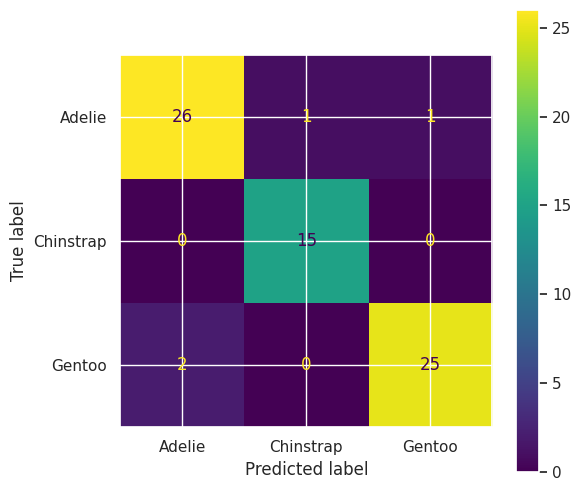

In [63]:
# Confusion matrix
y_pred = clf.predict(x_test_imputed)
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm, display_labels = clf.classes_)
fig, ax = plt.subplots(figsize=(6, 6))
cm_display.plot(ax=ax)
plt.show()

In [64]:
 ### druhý strom, radší koukněte, jestli to sedí, ja jsem to delala
 ### na validation setu předtím

In [145]:
dt = DecisionTreeClassifier(max_depth=50, random_state= seed)
dt.fit(x_train_imputed, y_train)
dt.get_params(True)

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 50,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 543,
 'splitter': 'best'}

In [134]:
from sklearn.model_selection import ParameterGrid
param_grid = {
    'max_depth': range(1,30),
    'criterion': ['entropy', 'gini']
}
param_comb = ParameterGrid(param_grid)
# just to see the result:
[param_comb[i] for i in range(30)]

[{'max_depth': 1, 'criterion': 'entropy'},
 {'max_depth': 2, 'criterion': 'entropy'},
 {'max_depth': 3, 'criterion': 'entropy'},
 {'max_depth': 4, 'criterion': 'entropy'},
 {'max_depth': 5, 'criterion': 'entropy'},
 {'max_depth': 6, 'criterion': 'entropy'},
 {'max_depth': 7, 'criterion': 'entropy'},
 {'max_depth': 8, 'criterion': 'entropy'},
 {'max_depth': 9, 'criterion': 'entropy'},
 {'max_depth': 10, 'criterion': 'entropy'},
 {'max_depth': 11, 'criterion': 'entropy'},
 {'max_depth': 12, 'criterion': 'entropy'},
 {'max_depth': 13, 'criterion': 'entropy'},
 {'max_depth': 14, 'criterion': 'entropy'},
 {'max_depth': 15, 'criterion': 'entropy'},
 {'max_depth': 16, 'criterion': 'entropy'},
 {'max_depth': 17, 'criterion': 'entropy'},
 {'max_depth': 18, 'criterion': 'entropy'},
 {'max_depth': 19, 'criterion': 'entropy'},
 {'max_depth': 20, 'criterion': 'entropy'},
 {'max_depth': 21, 'criterion': 'entropy'},
 {'max_depth': 22, 'criterion': 'entropy'},
 {'max_depth': 23, 'criterion': 'entropy'

In [138]:

train_acc = []
for params in param_comb:
    dt = DecisionTreeClassifier(max_depth=params['max_depth'], criterion=params['criterion'])
    dt.fit(x_train_imputed, y_train)
    train_acc.append(metrics.accuracy_score(y_train, dt.predict(x_train_imputed)))

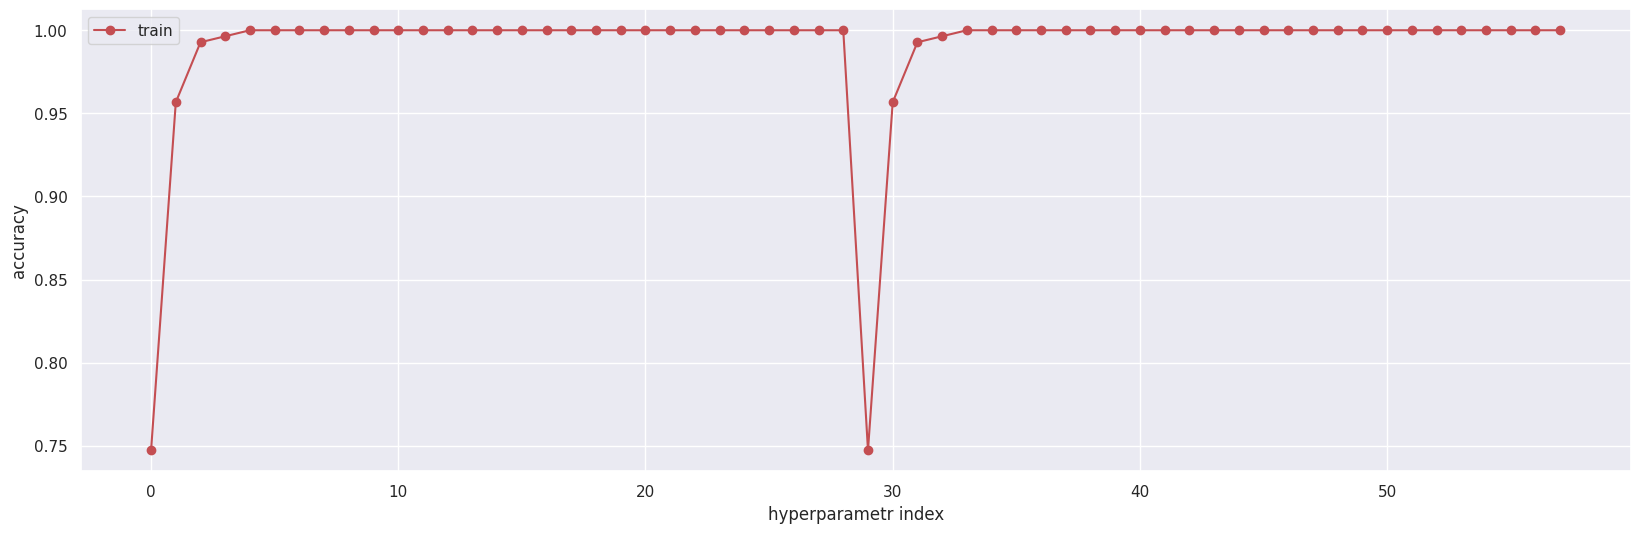

In [139]:
plt.figure(figsize=(20,6))
plt.plot(train_acc,'or-')

plt.xlabel('hyperparametr index')
plt.ylabel('accuracy')
plt.legend(['train' ])

In [140]:
best_params = param_comb[np.argmax(train_acc)]
best_params

{'max_depth': 5, 'criterion': 'entropy'}

In [141]:
dt = DecisionTreeClassifier(**best_params) 
dt.fit(x_train_imputed, y_train)
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(y_train, dt.predict(x_train_imputed))))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(y_test, dt.predict(x_test_imputed))))

accuracy score (train): 1.000000
accuracy score (test): 0.985714


In [149]:
get_features_importance(data, dt)

,Features,Importance
0,bill_length_mm,0.49
3,island_Biscoe,0.37
1,bill_depth_mm,0.08
5,island_Torgersen,0.07
2,body_mass_g,0.00


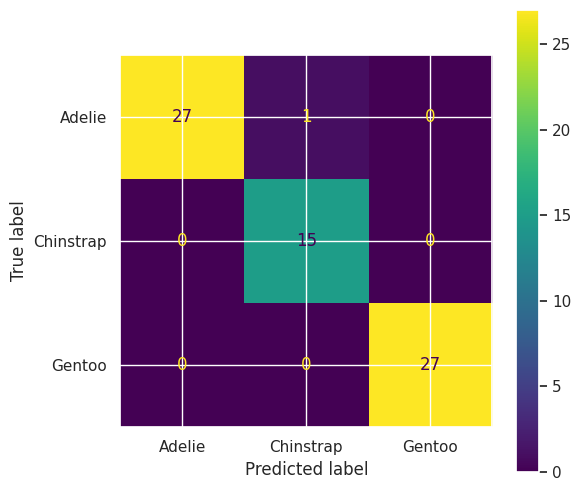

In [146]:
# Confusion matrix
y_pred = dt.predict(x_test_imputed)
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm, display_labels = clf.classes_)
fig, ax = plt.subplots(figsize=(6, 6))
cm_display.plot(ax=ax)
plt.show()

### Random forest

In [143]:
# Hyperparameter tuning
# Fitting 3 folds for each of 288 candidates, totalling 864 fits
"""
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
"""

# Best params found:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80],
    'max_features': [2],
    'min_samples_leaf': [3],
    'min_samples_split': [8],
    'n_estimators': [200]
}

rf = RandomForestClassifier(random_state=seed)
RFC_GS = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2) # cross validation
y_pred_rfgc = evaluate_model(model = RFC_GS, model_name = "Random Forest Classifier", X_test = x_test_imputed, y_test = y_test, tuning = True)

Fitting 3 folds for each of 1 candidates, totalling 3 fits

************ Random Forest Classifier ************

Best params found: {'bootstrap': True, 'max_depth': 80, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 200}

Accuracy: 99 %
Precision: 0.98
Recall: 0.99
F1-score: 0.98

***********************************************


In [ ]:
get_features_importance(data, RFC_GS) # tady můžeme možná spojit islad_xx dohromady? něco podobného jsme dělali na hodině

In [ ]:
# Confusion matrix
y_pred = RFC_GS.predict(x_test_imputed)
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm, display_labels = clf.classes_)
fig, ax = plt.subplots(figsize=(6, 6))
cm_display.plot(ax=ax)
plt.show()

### XGB Classifier

In [150]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [151]:
#Fitting 5 folds for each of 9 candidates, totalling 45 fits
params = {'n_estimators': stats.randint(150, 1000),
          'learning_rate': stats.uniform(0.01, 0.6),
          'min_child_weight': [1, 5, 10],
          'gamma': [0.5, 1, 1.5, 2, 5],
          'subsample': [0.6, 0.8, 1.0],
          'colsample_bytree': [0.6, 0.8, 1.0],
          'max_depth': [6,7,8,9,10]}

# Best params found: {'colsample_bytree': 0.6, 'gamma': 1, 'learning_rate': 0.16968966159024765, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 327, 'subsample': 1.0}
# Best params found: {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.09831984192178707, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 164, 'subsample': 1.0}

xgb = XGBClassifier(random_state = seed)
rs = RandomizedSearchCV(xgb, param_distributions = params, n_iter = 9, n_jobs = 4, cv = 5, verbose = 3) # cross validation
evaluate_model(model = rs, model_name = "XGB Classifier", X_test = x_test_imputed, y_test = y_test, tuning = True)

Fitting 5 folds for each of 9 candidates, totalling 45 fits

************ XGB Classifier ************

Best params found: {'colsample_bytree': 1.0, 'gamma': 1.5, 'learning_rate': 0.12919697316669754, 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 809, 'subsample': 0.6}

Accuracy: 99 %
Precision: 0.98
Recall: 0.99
F1-score: 0.98

***********************************************


array([0, 0, 1, 0, 2, 2, 0, 0, 0, 2, 2, 1, 0, 2, 0, 1, 0, 0, 1, 0, 2, 2,
       2, 2, 0, 2, 1, 1, 2, 0, 2, 0, 0, 0, 1, 1, 2, 1, 0, 2, 2, 0, 0, 2,
       1, 2, 2, 2, 1, 2, 2, 0, 1, 0, 2, 1, 0, 1, 0, 1, 2, 2, 2, 2, 2, 0,
       1, 0, 0, 0])

In [152]:
get_features_importance(data, rs)

,Features,Importance
0,bill_length_mm,0.29
1,bill_depth_mm,0.20
4,island_Dream,0.20
2,body_mass_g,0.19
3,island_Biscoe,0.12


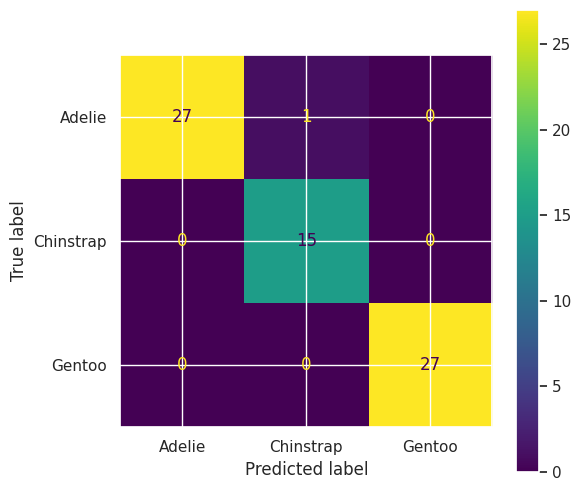

In [153]:
# Confusion matrix
y_pred = rs.predict(x_test_imputed)
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)
fig, ax = plt.subplots(figsize=(6, 6))
cm_display.plot(ax=ax)
plt.show()

### Logistic regression

In [157]:
param_grid = {'penalty' : ['l2'], 
              'C'       : [1.0, 0.9, 0.8, 0.7, 0.6],
              'solver'  : ['newton-cg', 'lbfgs', 'liblinear']}

logreg = LogisticRegression(max_iter = 300, random_state = seed)
logreg_cv = GridSearchCV(logreg, param_grid, cv = 5) # cross validation
evaluate_model(model = logreg_cv, model_name = "Logistic Regression", X_test = x_test_imputed, y_test = y_test, tuning = True)


************ Logistic Regression ************

Best params found: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}

Accuracy: 100 %
Precision: 1.0
Recall: 1.0
F1-score: 1.0

***********************************************


array([0, 0, 1, 0, 2, 2, 0, 0, 0, 2, 2, 1, 0, 2, 0, 1, 0, 0, 0, 0, 2, 2,
       2, 2, 0, 2, 1, 1, 2, 0, 2, 0, 0, 0, 1, 1, 2, 1, 0, 2, 2, 0, 0, 2,
       1, 2, 2, 2, 1, 2, 2, 0, 1, 0, 2, 1, 0, 1, 0, 1, 2, 2, 2, 2, 2, 0,
       1, 0, 0, 0])

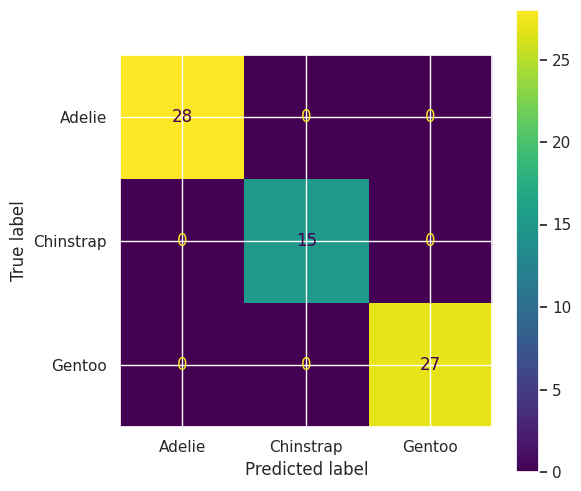

In [158]:
y_pred = logreg_cv.predict(x_test_imputed)
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm, display_labels = clf.classes_)
fig, ax = plt.subplots(figsize=(6, 6))
cm_display.plot(ax=ax)
plt.show()

## Evaluation

To evaluate the effectiveness of each model, we created a Confusion Matrix for every model and below each model we displayed four evaluation metrics:
* Accuracy
* Precision
* Recall (sensitivity)
* F1-score

These metrics are calculated for each class separately and then averaged, using macro-averaging method.
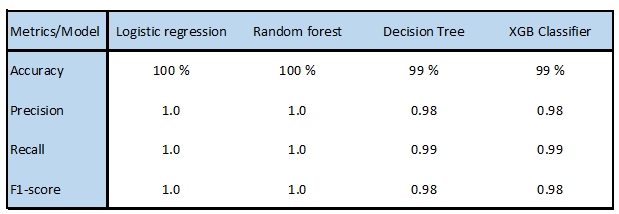

The logistic regression and random forest models both performed exceptionally well, achieving accuracy scores of 100%. Their precision, recall, and F1-score metrics were also excellent, indicating that these models did not make any false predictions and were highly effective at identifying penguin species based on physical characteristics and origin. While the decision tree and XGBoost models had slightly lower metrics, but they still performed reasonably well.

## Conclusion

Nejlepsi model...
Nejdulezitejsi features...

Otázky
* Popis log. regrese - proč jenom ridge. lassoo nešlo.
* Zdůvodnit výběr modelů. Zjistit výhody a nevýhody modelů.
* doplnit modely o věci z přednášek.
* Popsat nejdulezitejsi features
* Popsat features s nejmensim vlivem na model - případně tyto featury smazat.
* Pročíst přednášky